In [339]:
import requests
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly
import plotly.graph_objects as go

user_name  = "WalvinDesu"
data_source = "FILE"
filename = "lichess_WalvinDesu_2023-04-07.pgn"
time_control = "Blitz"

In [340]:
#Get user data via Python API
if data_source.upper() == "API":
    start_date = datetime.datetime(2022,2,1,0,0,0).timestamp()
    start_date = str(int(start_date*1000))
    x = requests.get(f"http://lichess.org/api/games/user/{user_name}?since={start_date}")
    #x = requests.get(f"http://lichess.org/api/games/user/{user_name}")
    chessdata = x.content.decode("utf-8")
#Or as a file    
elif data_source.upper() == "FILE":
    chessdata = open("../data/" + filename).read()
#Read the data as a list, dropping the final empty row    
chessdata = chessdata.split("\n\n\n")[:-1]

In [341]:
#Convert data to a DataFrame
def line2dict(line):
    data, game  = line.split("\n\n")
    data = data.replace("[","").replace("]","").replace('"', "")
    datadict = {x[0]:x[1] for l in data.split("\n")[:-1] for x in [l.split(" ",1)]}
    datadict["PGN"] = game
    return datadict
df = pd.DataFrame([line2dict(i) for i in chessdata])

In [342]:
#Process DataFrame
df = df[df["Event"].str.contains(time_control)]

df = df.set_index(pd.to_datetime(df["UTCDate"] + df["UTCTime"], format = "%Y.%m.%d%H:%M:%S"))
df = df.drop(["Date", "UTCDate", "UTCTime"], axis = 1)

df["UserColour"]     = np.where(df["White"] == user_name, "White", "Black")
df["OppName"]        = np.where(df["White"] == user_name, df["Black"], df["White"])
df["UserElo"]        = np.where(df["White"] == user_name, df["WhiteElo"], df["BlackElo"])
df["OppElo"]         = np.where(df["White"] == user_name, df["BlackElo"], df["WhiteElo"])
df["UserRatingDiff"] = np.where(df["White"] == user_name, df["WhiteRatingDiff"], df["BlackRatingDiff"])
df["OppRatingDiff"]  = np.where(df["White"] == user_name, df["BlackRatingDiff"], df["WhiteRatingDiff"])
df["WDL"]            = np.where(df["Result"] == "1/2-1/2", "D", 
                       np.where(((df["White"] == user_name) & (df["Result"] == "1-0")) | ((df["Black"] == user_name) & (df["Result"] == "0-1")), "W", "L"))
df = df.drop(["White", "Black", "WhiteElo", "BlackElo", "WhiteRatingDiff", "BlackRatingDiff", "Result", "FEN"], axis = 1)
#Convert ELO to float, removing provisional ELO ratings
df = df[(df["UserElo"].str[-1] != "?") & (df["OppElo"].str[-1] != "?")]
df["UserElo"] = df["UserElo"].astype(float)
df["OppElo"] = df["OppElo"].astype(float)


df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3487 entries, 2023-04-02 17:09:41 to 2019-06-07 22:24:18
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Event           3487 non-null   object 
 1   Site            3487 non-null   object 
 2   Variant         3487 non-null   object 
 3   TimeControl     3487 non-null   object 
 4   ECO             3487 non-null   object 
 5   PGN             3487 non-null   object 
 6   Termination     0 non-null      object 
 7   UserColour      3487 non-null   object 
 8   OppName         3487 non-null   object 
 9   UserElo         3487 non-null   float64
 10  OppElo          3487 non-null   float64
 11  UserRatingDiff  3483 non-null   object 
 12  OppRatingDiff   3483 non-null   object 
 13  WDL             3487 non-null   object 
dtypes: float64(2), object(12)
memory usage: 408.6+ KB


,Event,Site,Variant,TimeControl,ECO,PGN,Termination,UserColour,OppName,UserElo,OppElo,UserRatingDiff,OppRatingDiff,WDL
2023-04-02 17:09:41,Rated Blitz game,https://lichess.org/lay7uTkd,Standard,300+3,C42,1. e4 e5 2. Nf3 Nf6 3. Nxe5 d6 4. Nc4 Nxe4 5. ...,NaN,Black,VagnerRamos,1582.0,1620.0,-5,+5,L
2023-04-02 01:55:35,≤2000 Blitz Arena,https://lichess.org/7tvF7h2o,Standard,180+2,A40,1. d4 g6 2. Nf3 Bg7 3. Bf4 b6 4. e3 Bb7 5. Bd3...,NaN,White,dinlereren,1580.0,1714.0,+2,-2,D
2023-04-02 01:49:09,≤2000 Blitz Arena,https://lichess.org/s6ZyXKoq,Standard,180+2,C47,1. e4 e5 2. Nf3 Nf6 3. Nc3 Nc6 4. d4 exd4 5. N...,NaN,Black,llamaduck,1575.0,1487.0,+5,-4,W
2023-04-02 01:43:56,≤2000 Blitz Arena,https://lichess.org/CaNAEUw9,Standard,180+2,D02,1. d4 Nf6 2. Nf3 d5 3. Bf4 e6 4. c3 Bd6 5. Bg3...,NaN,White,BenjaminB78,1573.0,1302.0,+2,-2,W
2023-04-02 01:37:43,≤2000 Blitz Arena,https://lichess.org/g9YaX6Hp,Standard,180+2,C25,1. e4 e5 2. Nc3 Nc6 3. Bc4 Bc5 4. d3 d6 5. Nge...,NaN,Black,ORION-313,1571.0,1372.0,+2,-2,W


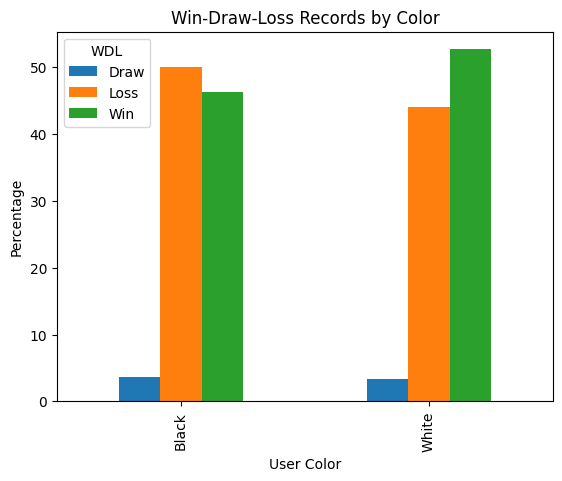

In [350]:
#Grouped bar chart for wins losses draws as white and black
wdl_pivot = pd.pivot_table(df, index="UserColour", columns="WDL", aggfunc="size")
wdl_pivot = wdl_pivot.div(wdl_pivot.sum(axis=1), axis =0)*100

fig, ax = plt.subplots()
wdl_pivot.plot(kind="bar", ax=ax)
ax.set_xlabel("User Color")
ax.set_ylabel("Percentage")
ax.set_title("Win-Draw-Loss Records by Color")
ax.legend(title="WDL", labels = ["Draw","Loss", "Win"])
plt.show()

In [344]:
#Create daily statistics Dataframe
daily_user_data              = df["UserElo"].resample("D",offset= "6H").ohlc()
daily_user_data["NumGames"]  = df["UserElo"].resample("D", offset="6H").count()
daily_user_data["WinCount"]  = df[df["WDL"]=="W"]["UserElo"].resample("D", offset="6H").count()
daily_user_data["LossCount"] = df[df["WDL"]=="L"]["UserElo"].resample("D", offset="6H").count()
daily_user_data["DrawCount"] = df[df["WDL"]=="D"]["UserElo"].resample("D", offset="6H").count()

daily_user_data.info()
daily_user_data


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1396 entries, 2019-06-07 06:00:00 to 2023-04-02 06:00:00
Freq: D
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       297 non-null    float64
 1   high       297 non-null    float64
 2   low        297 non-null    float64
 3   close      297 non-null    float64
 4   NumGames   1396 non-null   int64  
 5   WinCount   790 non-null    float64
 6   LossCount  1396 non-null   int64  
 7   DrawCount  736 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 98.2 KB


,open,high,low,close,NumGames,WinCount,LossCount,DrawCount
2019-06-07 06:00:00,1500.0,1500.0,1500.0,1500.0,1,NaN,1,NaN
2019-06-08 06:00:00,NaN,NaN,NaN,NaN,0,NaN,0,NaN
2019-06-09 06:00:00,NaN,NaN,NaN,NaN,0,NaN,0,NaN
2019-06-10 06:00:00,NaN,NaN,NaN,NaN,0,NaN,0,NaN
2019-06-11 06:00:00,NaN,NaN,NaN,NaN,0,NaN,0,NaN
...,...,...,...,...,...,...,...,...
2023-03-29 06:00:00,1598.0,1606.0,1593.0,1606.0,6,4.0,2,0.0
2023-03-30 06:00:00,1612.0,1628.0,1612.0,1624.0,5,3.0,2,0.0
2023-03-31 06:00:00,1616.0,1616.0,1610.0,1610.0,2,1.0,1,0.0
2023-04-01 06:00:00,1618.0,1618.0,1571.0,1580.0,41,16.0,22,3.0


In [345]:
fig = go.Figure(data =[go.Candlestick(x=user_elo_ohlc.index,
                open =daily_user_data['open'],
                high =daily_user_data['high'],
                low  =daily_user_data['low'],
                close=daily_user_data['close'])])

fig.show()

In [346]:
(user_elo_ohlc["close"].pct_change() * 100).mean()


0.02015054462214679

In [347]:
#Mald index - number of resignations, number of losses, time to resign etc see if it predicts future losses
#see if time of day predicts losses/wins
#openings frequency? tree where each leaf gives W/L rate
#number of losses per day #number of games per day
#get btc data
#win more as black?
#how much elo have you gained vs taken from opponents
#Run np.where steps to check the condition only once and make all the changes when necessary.